## Problem Statement
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. A US bike-sharing provider BoomBikes has decided to come up with a mindful business plan to be able to accelerate its revenue.

## Business Goal:
The purpose is to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. 

## Data Definition
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore') # Suppress warnings
import pandas as pd
import numpy as np

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for linear regression and statistical analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Reading and understanding data

In [2]:
# Read the data from csv and check
bikeSharing = pd.read_csv("day.csv")
bikeSharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
bikeSharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
bikeSharing.shape

(730, 16)

No Null values present in any column.

In [5]:
# Dropping instant column which represents record index
bikeSharing.drop(["instant"], axis=1, inplace=True)
bikeSharing.shape

(730, 15)

# Target variable is cnt - Total number of rentals including casual and registered
Let's plot the data to try and see if linear regression makes sense

# 2. Visualizing and manipulating

<Figure size 1080x1440 with 0 Axes>

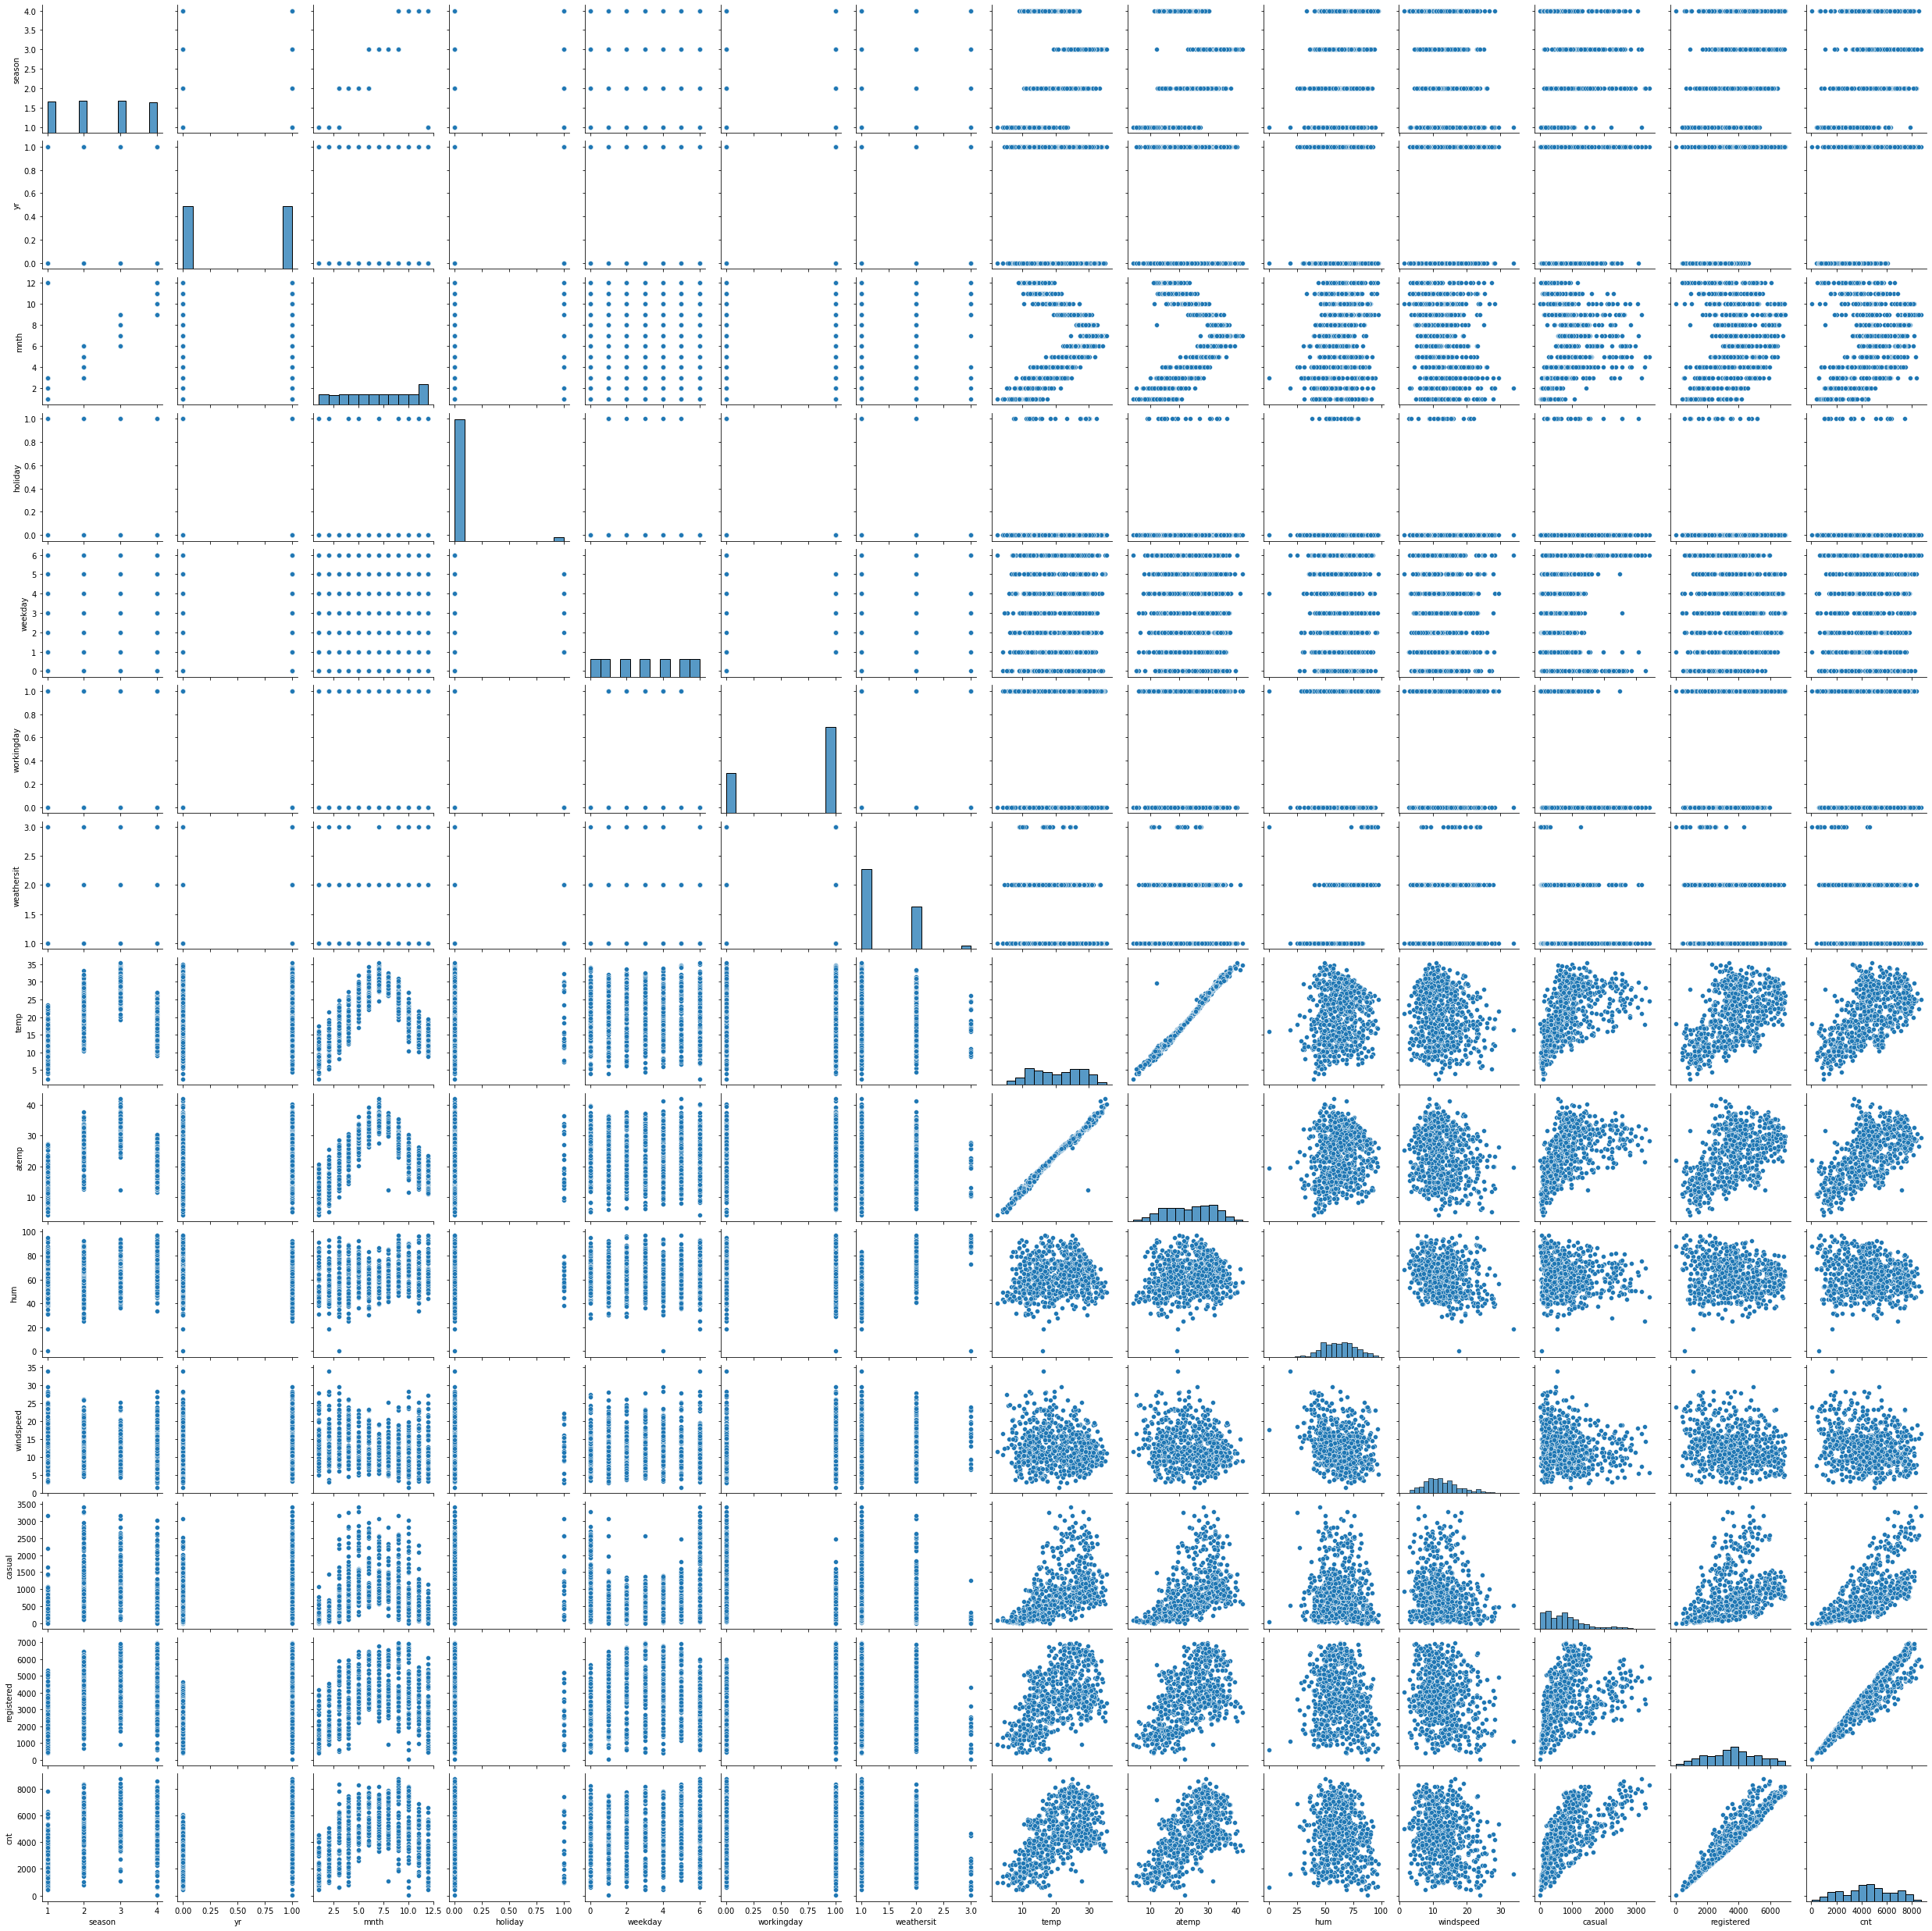

In [6]:
plt.figure(figsize=(15, 20))
sns.pairplot(bikeSharing)
plt.show()

<Figure size 1080x1440 with 0 Axes>

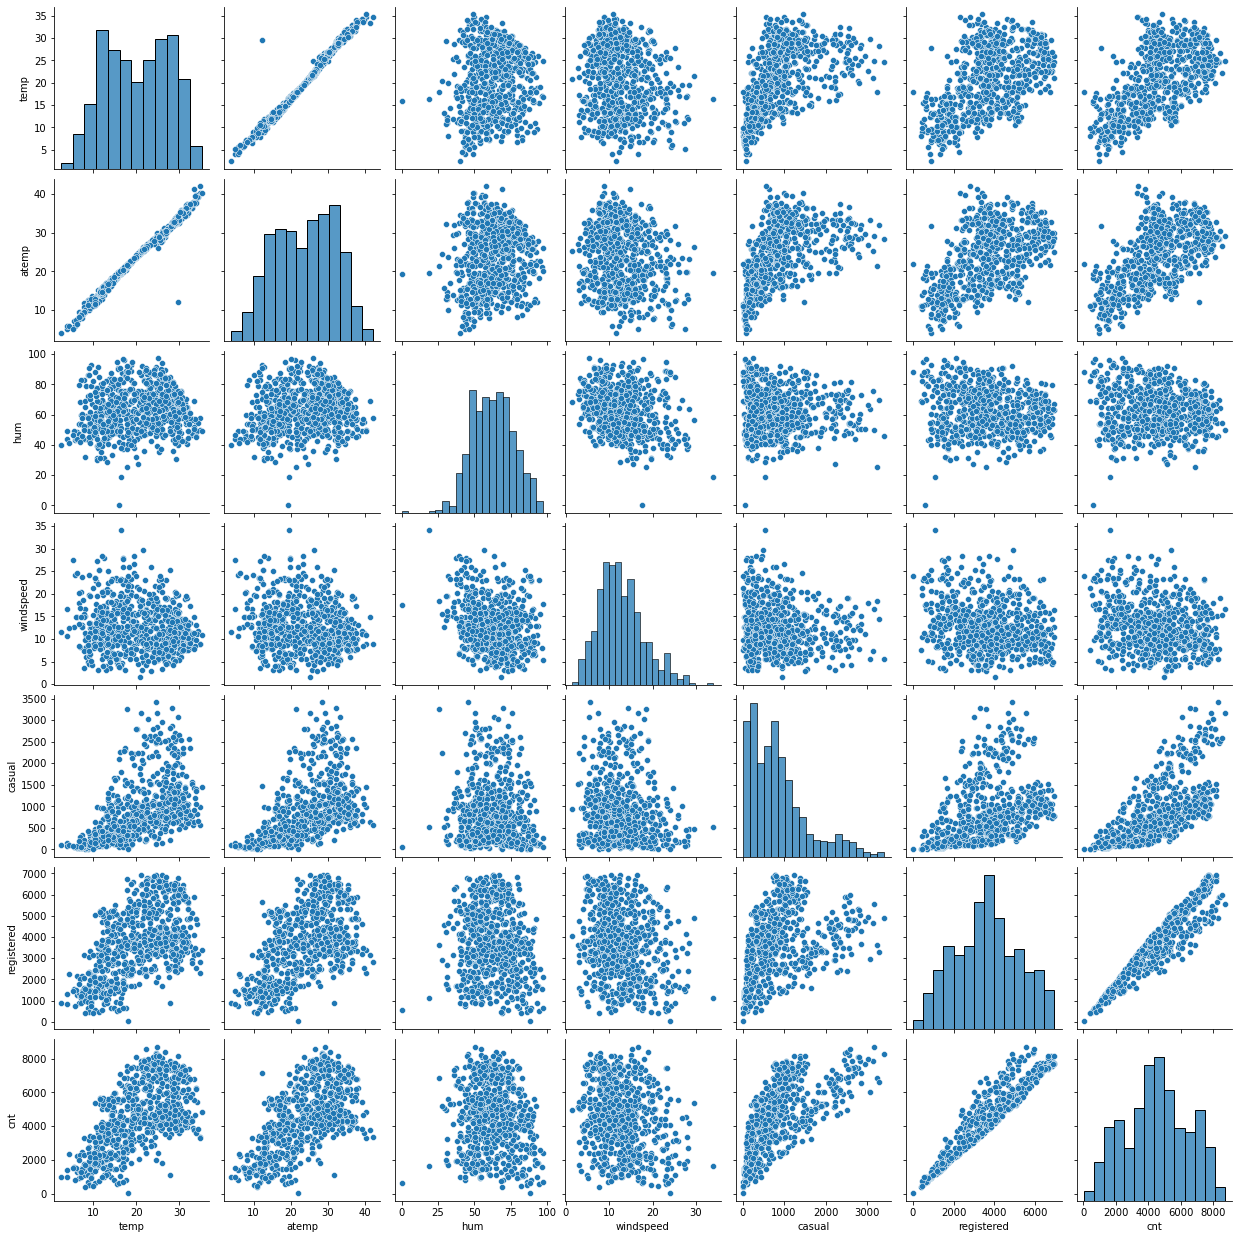

In [7]:
plt.figure(figsize=(15, 20))
ax = sns.pairplot(bikeSharing[["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]])
plt.show()

As we can see, few variables seem to have linear relation with cnt to some extent.

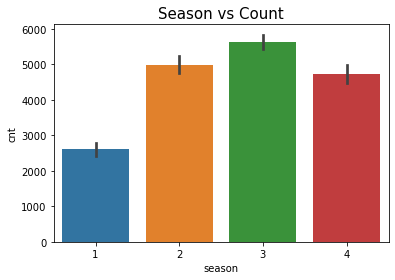

In [8]:
# Plotting cnt against season
ax = sns.barplot(data=bikeSharing, x="season", y="cnt")
ax.set_title("Season vs Count", fontsize=15)
plt.show()

Converting season into two buckets - 0 (Spring, Winter), 1(Summer, Fall)

In [9]:
bikeSharing.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [10]:
# Modifying season col values as strings, will use it later to derive dummy columns
bikeSharing.season = bikeSharing.season.apply(lambda x: "Spring" if (x==1) else "Summer" if (x==2) else "Fall" if (x==3) else "Winter")
bikeSharing.season.value_counts()

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64

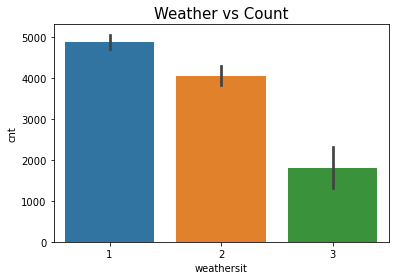

In [11]:
# Plotting cnt against weathrsit
ax = sns.barplot(data=bikeSharing, x="weathersit", y="cnt")
ax.set_title("Weather vs Count", fontsize=15)
plt.show()

Converting Weather into two buckets - 1 (Clear/Cloudy etc.), 0(snow, rain, storm etc.)

In [12]:
bikeSharing.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
# Modifying weathersit col values as strings, will use it later to derive dummy columns
bikeSharing.weathersit = bikeSharing.weathersit.apply(lambda x: "Clear" if (x==1) else "Cloudy" if (x==2) else "Light_snow_rain" if (x==3) else "Heavy_snow_rain")
bikeSharing.weathersit.value_counts()

Clear              463
Cloudy             246
Light_snow_rain     21
Name: weathersit, dtype: int64

In [14]:
# Convert casual and registered as percentage of cnt
bikeSharing.casual = round((bikeSharing.casual/bikeSharing.cnt), 2)
bikeSharing.casual.describe()

count    730.000000
mean       0.175808
std        0.107412
min        0.010000
25%        0.100000
50%        0.150000
75%        0.217500
max        0.510000
Name: casual, dtype: float64

In [15]:
bikeSharing.registered = round((bikeSharing.registered/bikeSharing.cnt), 2)
bikeSharing.registered.describe()

count    730.000000
mean       0.824192
std        0.107412
min        0.490000
25%        0.782500
50%        0.850000
75%        0.900000
max        0.990000
Name: registered, dtype: float64

In [16]:
bikeSharing.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,Spring,0,1,0,6,0,Cloudy,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985
1,02-01-2018,Spring,0,1,0,0,0,Cloudy,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801
2,03-01-2018,Spring,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349
3,04-01-2018,Spring,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562
4,05-01-2018,Spring,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600


# 3. Data Preparation

Will derive dummy columns from season and weathersit, and scale the data

In [17]:
season_dummy = pd.get_dummies(bikeSharing.season, drop_first=True)
season_dummy.head()

,Spring,Summer,Winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [18]:
bikeSharing = pd.concat([bikeSharing, season_dummy], axis=1)
bikeSharing.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter
0,01-01-2018,Spring,0,1,0,6,0,Cloudy,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0
1,02-01-2018,Spring,0,1,0,0,0,Cloudy,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0
2,03-01-2018,Spring,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0
3,04-01-2018,Spring,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0
4,05-01-2018,Spring,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0


In [19]:
bikeSharing.drop(["season"], axis=1, inplace=True)
bikeSharing.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter
0,01-01-2018,0,1,0,6,0,Cloudy,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0
1,02-01-2018,0,1,0,0,0,Cloudy,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0
2,03-01-2018,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0
3,04-01-2018,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0
4,05-01-2018,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0


In [20]:
weather_dummy = pd.get_dummies(bikeSharing.weathersit, drop_first=True)
weather_dummy.head()

,Cloudy,Light_snow_rain
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [21]:
bikeSharing = pd.concat([bikeSharing, weather_dummy], axis=1)
bikeSharing.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter,Cloudy,Light_snow_rain
0,01-01-2018,0,1,0,6,0,Cloudy,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0,1,0
1,02-01-2018,0,1,0,0,0,Cloudy,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0,1,0
2,03-01-2018,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0,0,0
3,04-01-2018,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0,0,0
4,05-01-2018,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0,0,0


In [22]:
bikeSharing.drop("weathersit", axis=1, inplace=True)
bikeSharing.head()

,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter,Cloudy,Light_snow_rain
0,01-01-2018,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0,1,0
1,02-01-2018,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0,1,0
2,03-01-2018,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0,0,0
3,04-01-2018,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0,0,0
4,05-01-2018,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0,0,0


In [23]:
# Converting dteday to extract date, since month and year already available in separate cols. Linear regression does not work --
# -- on date, has to be converted to numerical values
bikeSharing["date"] = pd.to_datetime(bikeSharing.dteday, dayfirst=True).dt.day
bikeSharing.head()

,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter,Cloudy,Light_snow_rain,date
0,01-01-2018,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0,1,0,1
1,02-01-2018,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0,1,0,2
2,03-01-2018,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0,0,0,3
3,04-01-2018,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0,0,0,4
4,05-01-2018,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0,0,0,5


In [24]:
# drop dteday
bikeSharing.drop("dteday", axis=1, inplace=True)
bikeSharing.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter,Cloudy,Light_snow_rain,date
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,0.34,0.66,985,1,0,0,1,0,1
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,0.16,0.84,801,1,0,0,1,0,2
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,0.09,0.91,1349,1,0,0,0,0,3
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,0.07,0.93,1562,1,0,0,0,0,4
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,0.05,0.95,1600,1,0,0,0,0,5


# 4. Split data into train and test sets

In [25]:
# Set the seed so that train and test will always have the same rows
np.random.seed(0) 

In [26]:
bikeSharing_train, bikeSharing_test = train_test_split(bikeSharing, train_size=0.7, test_size=0.3, random_state=100)

In [27]:
bikeSharing_train.shape

(510, 18)

In [28]:
bikeSharing_test.shape

(219, 18)

# 5. Re-scaling

In [29]:
# Using MinMaxScaler
scaler = MinMaxScaler()

In [30]:
# Take all the columns except 1/0 and dummy
cols = ["mnth", "weekday", "temp", "atemp", "hum", "windspeed", "casual", "registered", "date", "cnt"]

In [31]:
# Re-scale train set
bikeSharing_train[cols] = scaler.fit_transform(bikeSharing_train[cols])

In [32]:
bikeSharing_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,Spring,Summer,Winter,Cloudy,Light_snow_rain,date
653,1,0.818182,0,0.333333,1,0.509887,0.501133,0.575354,0.300794,0.22,0.78,0.864243,0,0,1,0,0,0.500000
576,1,0.545455,0,0.333333,1,0.815169,0.766351,0.725633,0.264686,0.24,0.76,0.827658,0,0,0,0,0,1.000000
426,1,0.181818,0,1.000000,0,0.442393,0.438975,0.640189,0.255342,0.46,0.54,0.465255,1,0,0,1,0,0.066667
728,1,1.000000,0,0.000000,0,0.245101,0.200348,0.498067,0.663106,0.38,0.62,0.204096,1,0,0,0,0,0.966667
482,1,0.272727,0,1.000000,0,0.395666,0.391735,0.504508,0.188475,0.52,0.48,0.482973,0,1,0,1,0,0.900000


# 6. Feature selection using RFE

In [33]:
# X and y sets for model
y_train = bikeSharing_train.pop("cnt")
X_train = bikeSharing_train

In [34]:
y_train.head()

653    0.864243
576    0.827658
426    0.465255
728    0.204096
482    0.482973
Name: cnt, dtype: float64

In [35]:
X_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,Spring,Summer,Winter,Cloudy,Light_snow_rain,date
653,1,0.818182,0,0.333333,1,0.509887,0.501133,0.575354,0.300794,0.22,0.78,0,0,1,0,0,0.500000
576,1,0.545455,0,0.333333,1,0.815169,0.766351,0.725633,0.264686,0.24,0.76,0,0,0,0,0,1.000000
426,1,0.181818,0,1.000000,0,0.442393,0.438975,0.640189,0.255342,0.46,0.54,1,0,0,1,0,0.066667
728,1,1.000000,0,0.000000,0,0.245101,0.200348,0.498067,0.663106,0.38,0.62,1,0,0,0,0,0.966667
482,1,0.272727,0,1.000000,0,0.395666,0.391735,0.504508,0.188475,0.52,0.48,0,1,0,1,0,0.900000


In [36]:
# Preparing lm RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [37]:
# RFE using top 12 cols
rfe = RFE(lm, 12).fit(X_train, y_train)
rfe

RFE(estimator=LinearRegression(), n_features_to_select=12)

In [38]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 6),
 ('holiday', True, 1),
 ('weekday', False, 3),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 2),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('casual', True, 1),
 ('registered', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 4),
 ('Winter', True, 1),
 ('Cloudy', True, 1),
 ('Light_snow_rain', True, 1),
 ('date', False, 5)]

In [39]:
selectedCols = X_train.columns[rfe.support_]
selectedCols

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'Spring', 'Winter', 'Cloudy', 'Light_snow_rain'],
      dtype='object')

In [40]:
# Filter X train columns based on RFE selection for model building
X_train_rfe = X_train[selectedCols]
X_train_rfe.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,Spring,Winter,Cloudy,Light_snow_rain
653,1,0,1,0.509887,0.575354,0.300794,0.22,0.78,0,1,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.24,0.76,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.46,0.54,1,0,1,0
728,1,0,0,0.245101,0.498067,0.663106,0.38,0.62,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.52,0.48,0,0,1,0


Now we proceed with model building with y_train and X_train_rfe

# 7. Model building

In [49]:
# Add a constant to X_train_rfe
X_train_model1 = sm.add_constant(X_train_rfe)

# Build model using Statsmodel
stModel1 = sm.OLS(endog=y_train, exog=X_train_model1, hasconst=True).fit()


In [50]:
# Parameters and summary of fitted model
print(stModel1.params)
print(stModel1.summary())

const              0.208734
yr                 0.240897
holiday           -0.058166
workingday         0.109063
temp               0.365819
hum               -0.105260
windspeed         -0.150149
casual             0.233027
registered        -0.024293
Spring            -0.096976
Winter             0.071085
Cloudy            -0.051392
Light_snow_rain   -0.222280
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.7
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          9.23e-190
Time:                        16:37:37   Log-Likelihood:                 504.89
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     498   BIC:                        

R-squared and adjusted R-squared are good. F_stat close to 0.
<br>Probability of coefficient of column "registered" is higher than others, can be dropped

In [43]:
# Calculate VIFs for model 1
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,registered,44.58
6,casual,12.47
2,workingday,3.64
3,temp,3.00
8,Spring,2.62
4,hum,1.86
9,Winter,1.84
10,Cloudy,1.57
11,Light_snow_rain,1.26
5,windspeed,1.18


In [48]:
# Dropping column registered
X2 = X_train_rfe.drop("registered", axis=1)
X2.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,Spring,Winter,Cloudy,Light_snow_rain
653,1,0,1,0.509887,0.575354,0.300794,0.22,0,1,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.24,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.46,1,0,1,0
728,1,0,0,0.245101,0.498067,0.663106,0.38,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.52,0,0,1,0


In [51]:
# Add a constant and build model 2
X_train_model2 = sm.add_constant(X2)
stModel2 = sm.OLS(endog=y_train, exog=X_train_model2, hasconst=True).fit()

In [53]:
# Parameters and summary of fitted model
print(stModel2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.7
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          9.23e-190
Time:                        16:38:52   Log-Likelihood:                 504.89
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     498   BIC:                            -935.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1844      0.038     

No change in R_squared/adjusted R_squared as expected, this signifies that col "registered" was indeed insignificant

In [54]:
# Calculate VIFs for model 2
vif = pd.DataFrame()
vif['Features'] = X2.columns
vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,25.53
3,temp,19.47
6,casual,9.88
2,workingday,7.72
5,windspeed,4.17
7,Spring,2.58
9,Cloudy,2.32
8,Winter,2.09
0,yr,2.07
10,Light_snow_rain,1.29


In [55]:
# Dropping col hum, since VIF is very high
X3 = X2.drop("hum", axis=1)
X3.head()

,yr,holiday,workingday,temp,windspeed,casual,Spring,Winter,Cloudy,Light_snow_rain
653,1,0,1,0.509887,0.300794,0.22,0,1,0,0
576,1,0,1,0.815169,0.264686,0.24,0,0,0,0
426,1,0,0,0.442393,0.255342,0.46,1,0,1,0
728,1,0,0,0.245101,0.663106,0.38,1,0,0,0
482,1,0,0,0.395666,0.188475,0.52,0,0,1,0


In [59]:
# Add a constant and build model 3
X_train_model3 = sm.add_constant(X3)
stModel3 = sm.OLS(endog=y_train, exog=X_train_model3, hasconst=True).fit()

In [60]:
# Parameters and summary of fitted model
print(stModel3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     256.1
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          2.63e-189
Time:                        16:42:26   Log-Likelihood:                 500.94
No. Observations:                 510   AIC:                            -979.9
Df Residuals:                     499   BIC:                            -933.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1219      0.031     

R_squared/f_statistics and probability of coefficients all look good

In [61]:
# Calculate VIFs for model 3
vif = pd.DataFrame()
vif['Features'] = X3.columns
vif['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,16.08
5,casual,8.58
2,workingday,6.62
4,windspeed,4.17
0,yr,2.07
6,Spring,2.00
7,Winter,1.52
8,Cloudy,1.51
9,Light_snow_rain,1.10
1,holiday,1.09


# 8. Prediction and Residual Analysis

# 9. Model Evaluation